## 1) Loading Data and Packages + Util

In [1]:
import os
from google.colab import files
import shutil

import math
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, RandomizedSearchCV, GridSearchCV, TunedThresholdClassifierCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import get_scorer_names, balanced_accuracy_score
import matplotlib.pyplot as plt
from typing_extensions import final
import seaborn as sns
import random

from collections import OrderedDict

Load data from local folder

In [3]:
os.makedirs('/content/data', exist_ok=True)
destination_folder = '/content/data'
uploaded = files.upload()
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(destination_folder, filename))

Saving full_fb_data.csv to full_fb_data.csv


Setup fitbit_data

In [4]:
fitbit_data = pd.read_csv('/content/data/data_daily_w_visits.csv')
all_fitbit_data = pd.read_csv('/content/data/all_fitbit_data_daily_w_visit.csv')
full_fb_data = pd.read_csv('/content/data/full_fb_data.csv')
adh_data = pd.read_csv('/content/data/adh.csv')

In [5]:
# Organizing columns
measure_features = ['calories', 'heart', 'steps']
survey_features = ['diet', 'medication', 'symptoms']
target_col = 'visit_day'
all_features = ['avgWeight_per_day',
       'calories', 'heart', 'steps', 'minutes_asleep', 'minutes_awake', 'temp/skin_nightlyRelative',
       'spo2_avg', 'spo2_min', 'spo2_max', 'hrv_dailyRmssd', 'hrv_deepRmssd',
       'br_breathingRate', 'out_of_range_zone_cal', 'out_of_range_zone_max_hr',
       'out_of_range_zone_min_hr', 'fat_burn_zone_cal', 'fat_burn_zone_max_hr',
       'fat_burn_zone_min_hr', 'cardio_zone_cal', 'cardio_zone_max_hr',
       'cardio_zone_min_hr', 'peak_zone_cal', 'peak_zone_max_hr',
       'peak_zone_min_hr', 'diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']
one_h_feaatures = ['diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']
adh_info = ['synced_fitbit', 'checked_weight',	'did_survey',	'fb_streak',
            'bt_streak',	'surv_streak', 'above_min_thresh',
            'percent_of_day_worn',	'above_thresh']

In [6]:
# Ensure date is datetime and sort
fitbit_data['date'] = pd.to_datetime(fitbit_data['date'])
fitbit_data = fitbit_data.sort_values(by=['fitbit_user_id', 'date'])
all_fitbit_data['date'] = pd.to_datetime(all_fitbit_data['date'])
all_fitbit_data = all_fitbit_data.sort_values(by=['fitbit_user_id', 'date'])
full_fb_data['date'] = pd.to_datetime(full_fb_data['date'])
full_fb_data = full_fb_data.sort_values(by=['fitbit_user_id', 'date'])

# Shift survey columns
for col in survey_features:
  fitbit_data[col] = fitbit_data.groupby('fitbit_user_id')[col].shift(-1)
  all_fitbit_data[col] = all_fitbit_data.groupby('fitbit_user_id')[col].shift(-1)
  full_fb_data[col] = full_fb_data.groupby('fitbit_user_id')[col].shift(-1)

# Set remaining nan visit columns to 0
fitbit_data[target_col] = fitbit_data[target_col].fillna(0)
all_fitbit_data[target_col] = all_fitbit_data[target_col].fillna(0)
full_fb_data[target_col] = full_fb_data[target_col].fillna(0)

In [7]:
full_fb_data['has_visit'] = 0

for user_id, group in full_fb_data.groupby('fitbit_user_id'):
    if group[target_col].sum() != 0:
        full_fb_data.loc[group.index, 'has_visit'] = 1

In [21]:
def zscore_userwise(df, features):
    df_z = df.copy()
    for col in features:
        means = df.groupby('fitbit_user_id')[col].transform('mean')
        stds  = df.groupby('fitbit_user_id')[col].transform('std')
        df_z[col + '_z'] = (df[col] - means) / stds
    return df_z

In [157]:
def zscore_rolling(df, features, bootstrap_n=3):
    df_z = df.copy()

    for col in features:
        df_z[col + '_z'] = np.nan

        for user_id, group in df.groupby('fitbit_user_id'):
            series = group[col]
            z = []
            past_vals = []

            # First phase: collect the first 3 non-NaN values
            idxs = series.index.tolist()
            collected = 0

            for idx in idxs:
                val = series.loc[idx]

                if pd.isna(val):
                    z.append(np.nan)
                else:
                    past_vals.append(val)
                    collected += 1
                    z.append(None)  # placeholder to be replaced later

                if collected == bootstrap_n:
                    break

            # If we got enough to bootstrap, calculate mean/std and assign z-scores
            if len(past_vals) == bootstrap_n:
                mean = np.mean(past_vals)
                std = np.std(past_vals, ddof=1)
                z_vals = [(v - mean) / std if std > 0 else 0 for v in past_vals]

                # Replace placeholders
                for i in range(len(z)):
                    if z[i] is None:
                        z[i] = z_vals.pop(0)

            # Continue with the rest
            for idx in idxs[len(z):]:
                val = series.loc[idx]

                if pd.isna(val):
                    z.append(np.nan)
                    continue

                past_vals.append(val)
                mean = np.mean(past_vals)
                std = np.std(past_vals, ddof=1)
                z_val = (val - mean) / std if std > 0 else 0
                z.append(z_val)

            df_z.loc[series.index, col + '_z'] = z

    return df_z


In [158]:
z_features = ['avgWeight_per_day', 'calories', 'heart', 'steps', 'hrv_dailyRmssd', 'hrv_deepRmssd']

z_fb_data = zscore_rolling(full_fb_data, z_features)

In [23]:
def extract_days_before_visit(df, days_before=14):
    output_rows = []

    for user_id, group in df.groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)
        visit_indices = group.index[group['visit_day'] == 1].tolist()

        if not visit_indices:
            continue  # Skip users with no visits

        first_visit_idx = visit_indices[0]
        visit_day = group.loc[first_visit_idx, 'days']

        # Slice window before visit
        visit_window = group[(group['days'] >= visit_day - days_before) & (group['days'] <= visit_day)].copy()

        # Add relative day to visit
        visit_window['days_to_visit'] = visit_window['days'] - visit_day
        visit_window['fitbit_user_id'] = user_id

        output_rows.append(visit_window)

    result_df = pd.concat(output_rows, axis=0).reset_index(drop=True)

    return result_df

In [24]:
def extract_days_no_visits(df, window_days=15, max_windows=3, seed=42):
    np.random.seed(seed)
    output_rows = []

    for user_id, group in df[df['has_visit'] == 0].groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)

        min_day = group['days'].min()
        max_day = group['days'].max()

        possible_starts = list(range(min_day, max_day - window_days + 1))
        np.random.shuffle(possible_starts)

        windows_added = 0

        for start in possible_starts:
            end = start + window_days
            window = group[(group['days'] >= start) & (group['days'] < end)].copy()

            if len(window) == window_days:  # Complete window
                window['days_to_window'] = window['days'] - end + 1
                window['fitbit_user_id'] = user_id
                output_rows.append(window)
                windows_added += 1

            if windows_added >= max_windows:
                break

    return pd.concat(output_rows, axis=0).reset_index(drop=True)

In [159]:
two_week_visit = extract_days_before_visit(z_fb_data)
three_week_visit = extract_days_before_visit(z_fb_data, days_before=21)
two_week = extract_days_no_visits(z_fb_data)
three_week = extract_days_no_visits(z_fb_data, window_days=22)

In [235]:
three_week_visit

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,diet,medication,...,percent_of_day_worn,above_thresh,has_visit,avgWeight_per_day_z,calories_z,heart_z,steps_z,hrv_dailyRmssd_z,hrv_deepRmssd_z,days_to_visit
0,900,2021-08-10,App Money,7,123.789413,2342.0,103.0,3921.0,NaN,NaN,...,0.777778,1,1,-1.131697,0.325822,1.120897,0.735649,NaN,NaN,-21
1,901,2021-08-11,App Money,7,207.454742,2142.0,99.0,2152.0,NaN,NaN,...,0.568056,1,1,0.764458,-1.122275,-0.800641,-1.138613,NaN,NaN,-20
2,902,2021-08-12,App Money,7,NaN,2407.0,100.0,3607.0,NaN,NaN,...,0.512500,1,1,NaN,0.796453,-0.320256,0.402965,NaN,NaN,-19
3,903,2021-08-13,App Money,7,NaN,2671.0,NaN,5306.0,NaN,NaN,...,0.910417,1,1,NaN,1.284514,NaN,1.205049,NaN,NaN,-18
4,904,2021-08-14,App Money,7,NaN,2458.0,100.0,4340.0,NaN,NaN,...,0.780556,1,1,NaN,0.281972,-0.288675,0.41224,NaN,NaN,-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,41628,2024-07-03,App Money,284,245.594668,2120.0,72.0,1165.0,1.0,2.0,...,0.745833,1,1,-2.148255,-1.020837,0.201844,-1.223332,0.514629,-0.113195,-4
1044,41629,2024-07-04,App Money,284,241.846814,2342.0,74.0,1559.0,1.0,2.0,...,0.863194,1,1,-3.134266,0.316502,1.471262,-0.557534,NaN,NaN,-3
1045,41630,2024-07-05,App Money,284,242.287738,2214.0,75.0,1777.0,1.0,2.0,...,0.685417,1,1,-2.718668,-0.458317,2.013027,-0.188738,NaN,NaN,-2
1046,41631,2024-07-06,App Money,284,242.949124,2339.0,75.0,1760.0,1.0,2.0,...,0.831250,1,1,-2.343012,0.306539,1.919145,-0.215467,NaN,NaN,-1


In [243]:
def extract_random_days_before_visit_combined(df, days_before=15, max_windows=3, seed=42, exclude_window_before_visit=False):
    np.random.seed(seed)
    output_rows = []

    for user_id, group in df[df['has_visit'] == 1].groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)
        visit_indices = group.index[group['visit_day'] == 1].tolist()

        if not visit_indices:
            continue

        first_visit_day = group.loc[visit_indices[0], 'days']

        # Define max allowable end day based on flag
        if exclude_window_before_visit:
            max_end_day = first_visit_day - days_before  # force entire window before visit window
        else:
            max_end_day = first_visit_day  # allow any window before visit

        min_day = group['days'].min()
        max_start_day = max_end_day - days_before

        if max_start_day < min_day:
            continue  # not enough room for even one window

        possible_starts = list(range(min_day, max_start_day + 1))
        np.random.shuffle(possible_starts)

        windows_added = 0

        for start_day in possible_starts:
            end_day = start_day + days_before
            window = group[(group['days'] >= start_day) & (group['days'] < end_day)].copy()

            if len(window) == days_before:
                # Align to end of window like other no-visit functions
                window['days_to_window'] = window['days'] - (end_day - 1)
                window['fitbit_user_id'] = user_id
                output_rows.append(window)
                windows_added += 1

            if windows_added >= max_windows:
                break

    return pd.concat(output_rows, axis=0).reset_index(drop=True)


In [244]:
two_week_visit_random = extract_random_days_before_visit(z_fb_data)
three_week_visit_random = extract_random_days_before_visit(z_fb_data, days_before=22)
two_week_visit_random_window = extract_random_days_before_visit(z_fb_data, exclude_window_before_visit=True)
three_week_visit_random_window = extract_random_days_before_visit(z_fb_data, days_before=22, exclude_window_before_visit=True)

In [245]:
three_week_visit_random

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,diet,medication,...,above_thresh,has_visit,avgWeight_per_day_z,calories_z,heart_z,steps_z,hrv_dailyRmssd_z,hrv_deepRmssd_z,days_to_window,days_to_visit
0,2524,2021-10-02,No App,19,186.069928,1311.0,NaN,36.0,NaN,NaN,...,0,1,0.357295,0.331468,NaN,-0.229996,NaN,NaN,-21,-94
1,2525,2021-10-03,No App,19,186.290390,1310.0,NaN,16.0,NaN,NaN,...,0,1,0.477146,0.21118,NaN,-0.421456,NaN,NaN,-20,-93
2,2526,2021-10-04,No App,19,NaN,1304.0,NaN,0.0,NaN,NaN,...,0,1,NaN,-0.442011,NaN,-0.567937,NaN,NaN,-19,-92
3,2527,2021-10-05,No App,19,185.408542,1307.0,NaN,40.0,NaN,NaN,...,0,1,-0.293294,-0.066815,NaN,-0.027291,NaN,NaN,-18,-91
4,2528,2021-10-06,No App,19,NaN,1305.0,NaN,4.0,NaN,NaN,...,0,1,NaN,-0.315234,NaN,-0.51404,NaN,NaN,-17,-90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2701,41603,2024-06-08,App Money,284,252.428990,2143.0,72.0,1203.0,1.0,2.0,...,1,1,0.471952,-1.119119,-0.127448,-1.428574,-0.653449,-0.68301,-4,-29
2702,41604,2024-06-09,App Money,284,252.869914,2249.0,72.0,1524.0,1.0,2.0,...,1,1,0.591306,-0.495542,-0.124939,-0.805143,NaN,NaN,-3,-28
2703,41605,2024-06-10,App Money,284,252.208528,2190.0,72.0,1031.0,1.0,2.0,...,1,1,0.376745,-0.814003,-0.122573,-1.601431,-0.463956,-0.04408,-2,-27
2704,41606,2024-06-11,App Money,284,251.767604,2185.0,74.0,1526.0,1.0,2.0,...,1,1,0.232305,-0.817203,1.387777,-0.689629,-1.299507,-0.202151,-1,-26


## 2) Graphing

In [219]:
def plot_feature_comparison(df1, df2, feature, time_col1='days_to_visit', time_col2='days_to_window', label1='Visit Users', label2='No-Visit Users', bin_continuous=False, n_bins=10):
    # ------------------- Line Plot -------------------
    fig, ax = plt.subplots(figsize=(7, 4))

    # Group by time and compute mean
    avg1 = df1.groupby(time_col1)[feature].mean()
    avg2 = df2.groupby(time_col2)[feature].mean()

    ax.plot(avg1.index, avg1.values, marker='o', label=label1)
    ax.plot(avg2.index, avg2.values, marker='o', label=label2)

    ax.set_title(f"Average {feature} Over Time")
    ax.set_xlabel("Days")
    ax.set_ylabel(f"Average {feature}")
    ax.axvline(0, color='red', linestyle='--', label='Event Day')
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

     # ------------------- Helper to prepare bar plot data -------------------
    def prepare_for_stacked(df, tcol):
        df = df.copy()
        if bin_continuous:
            df[feature] = df[feature].apply(lambda x: 'Missing' if pd.isna(x) else 'Non-missing')
        else:
            df[feature] = df[feature].fillna('Missing').astype(str)
        return df.groupby([tcol, feature]).size().unstack(fill_value=0)

    ct1 = prepare_for_stacked(df1, time_col1)
    ct2 = prepare_for_stacked(df2, time_col2)

    # ------------------- Stacked Bar Plot (Counts) -------------------
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    ct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Counts")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Count")

    ct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Counts")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Count")
    plt.tight_layout()
    plt.show()

    # ------------------- Stacked Bar Plot (Percentages) -------------------
    pct1 = ct1.div(ct1.sum(axis=1), axis=0).fillna(0)
    pct2 = ct2.div(ct2.sum(axis=1), axis=0).fillna(0)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    pct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Percentages")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Proportion")
    axs[0].legend(title="Value", bbox_to_anchor=(1.05, 1), loc='upper left')

    pct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Percentages")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Proportion")
    axs[1].legend(title="Value", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [162]:
def drop_nan_user(df, feature):
    valid_users = df.groupby('fitbit_user_id')[feature].apply(lambda x: not x.isna().all())
    valid_user_ids = valid_users[valid_users].index

    return df[df['fitbit_user_id'].isin(valid_user_ids)].reset_index(drop=True)

### 2a) Three Week

In [163]:
three_week_visit_weight = drop_nan_user(three_week_visit, 'avgWeight_per_day_z')
three_week_weight = drop_nan_user(three_week, 'avgWeight_per_day_z')

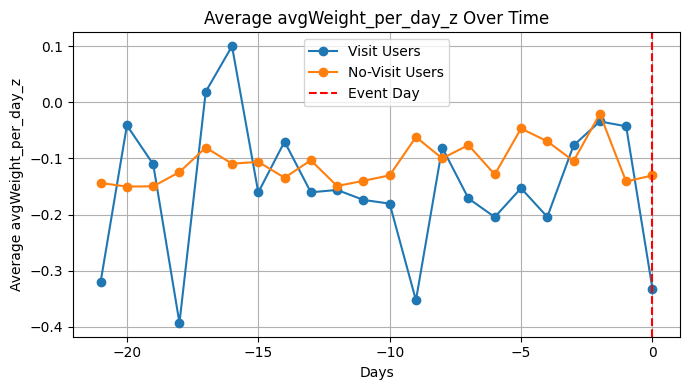

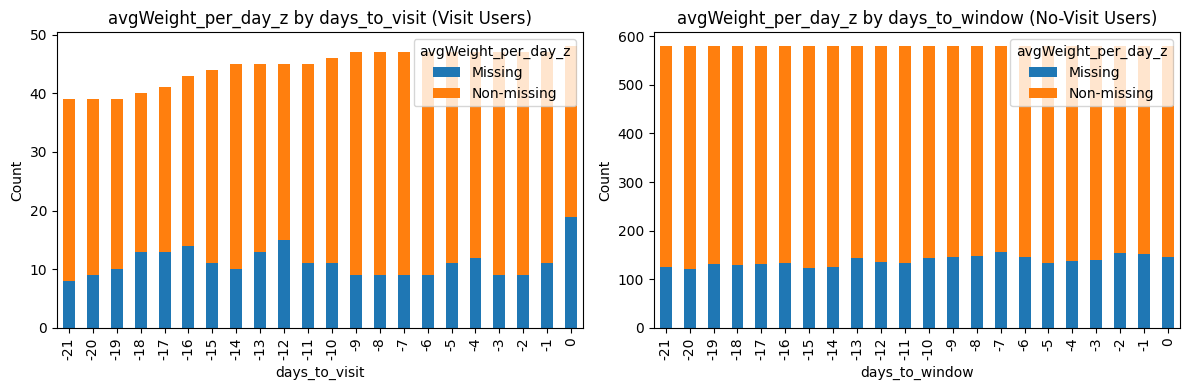

In [164]:
plot_feature_comparison(three_week_visit_weight, three_week_weight, 'avgWeight_per_day_z', bin_continuous=True, n_bins=10)

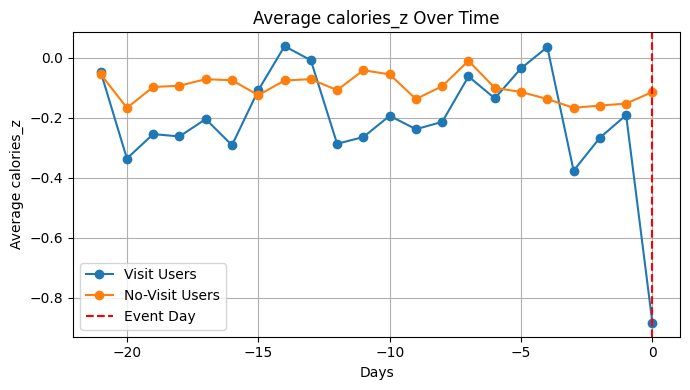

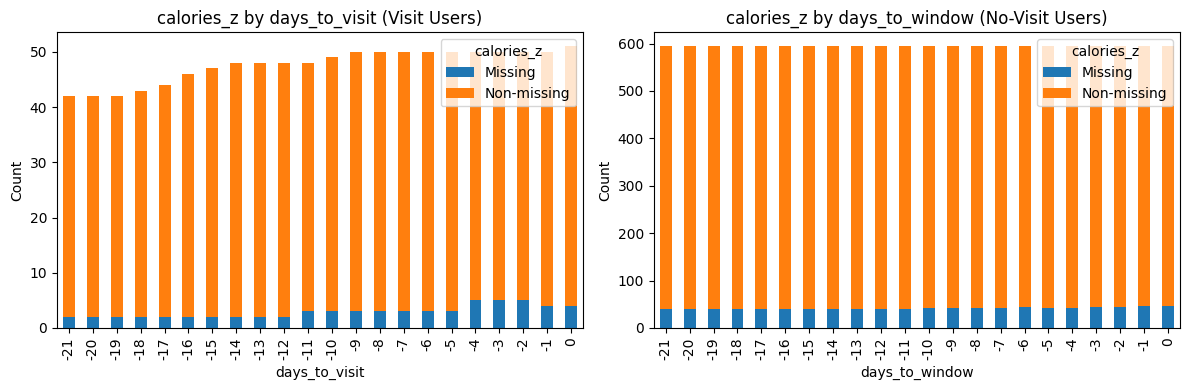

In [165]:
plot_feature_comparison(three_week_visit, three_week, 'calories_z', bin_continuous=True, n_bins=10)

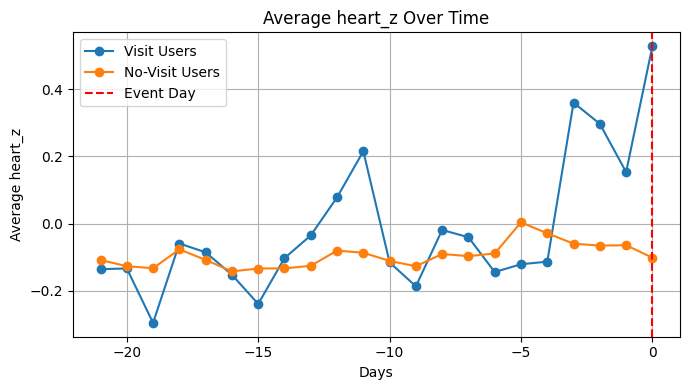

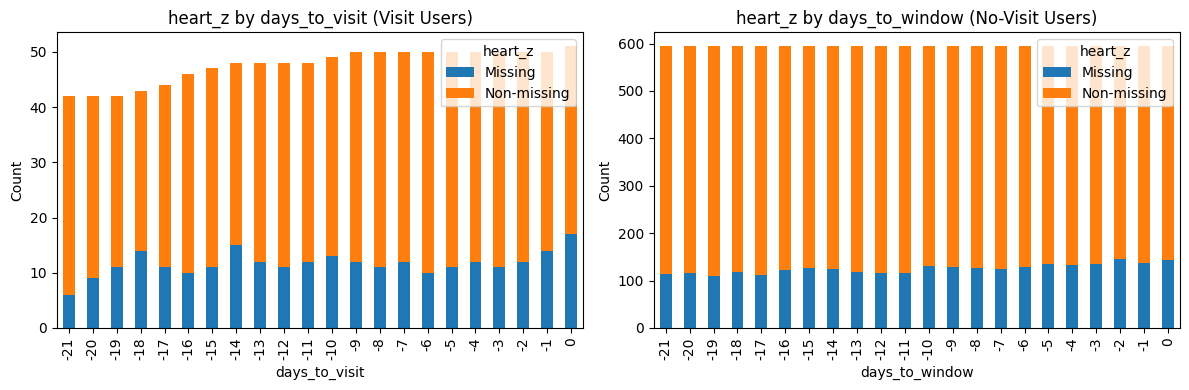

In [166]:
plot_feature_comparison(three_week_visit, three_week, 'heart_z', bin_continuous=True, n_bins=10)

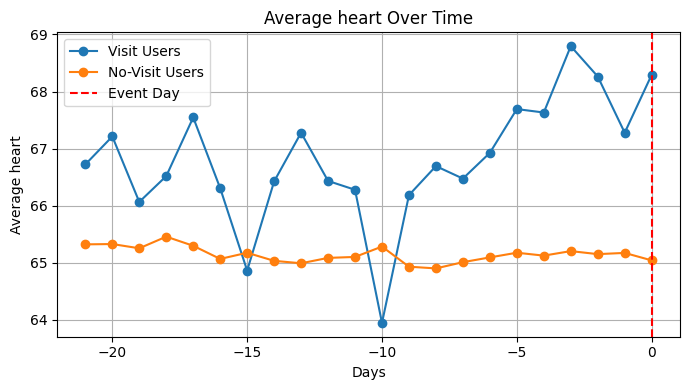

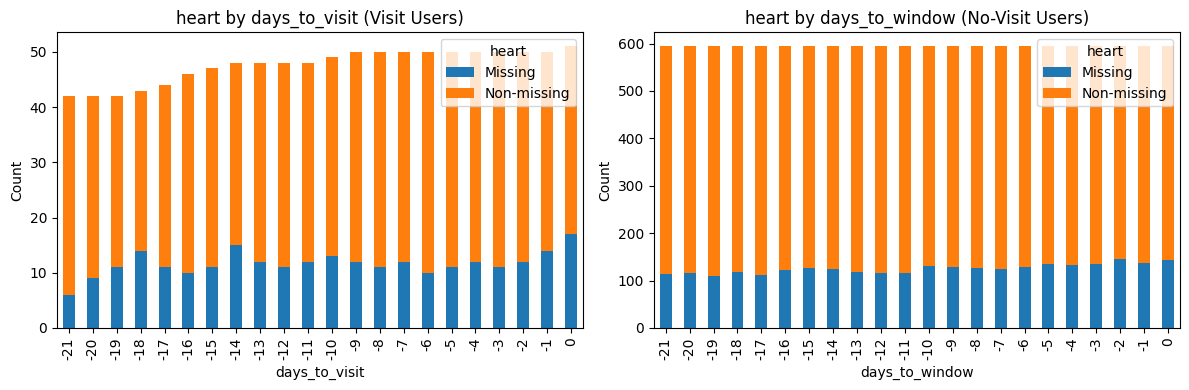

In [167]:
plot_feature_comparison(three_week_visit, three_week, 'heart', bin_continuous=True, n_bins=10)

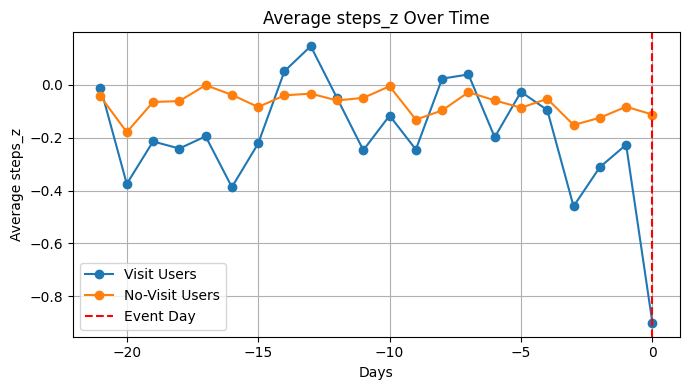

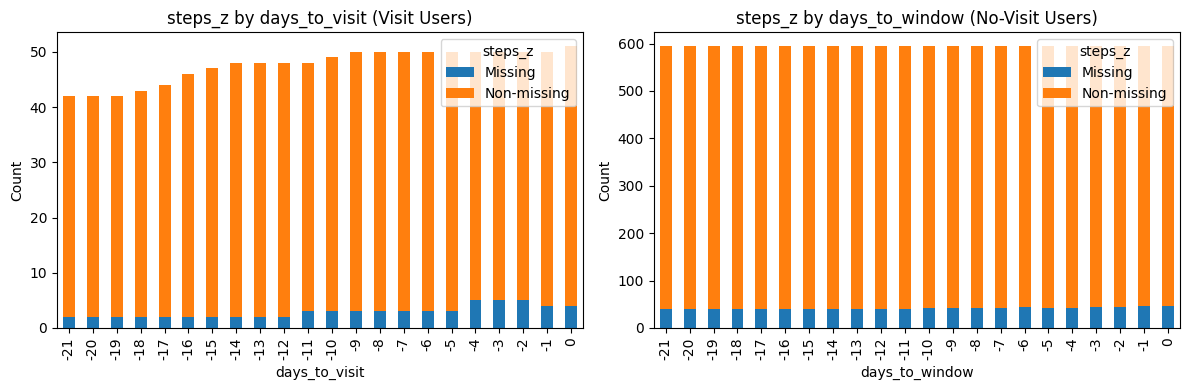

In [168]:
plot_feature_comparison(three_week_visit, three_week, 'steps_z', bin_continuous=True, n_bins=10)

In [169]:
three_week_visit_symptoms = drop_nan_user(three_week_visit, 'symptoms')
three_week_symptoms = drop_nan_user(three_week, 'symptoms')

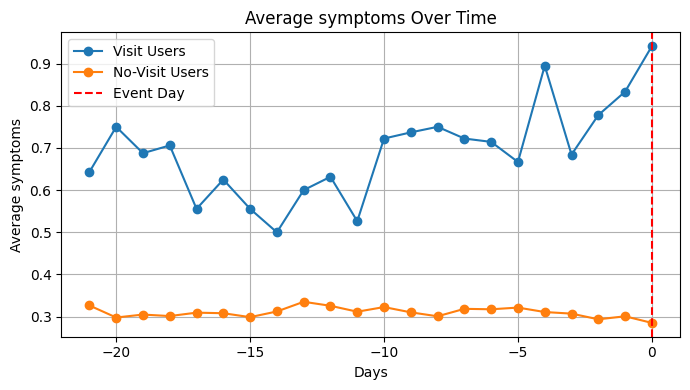

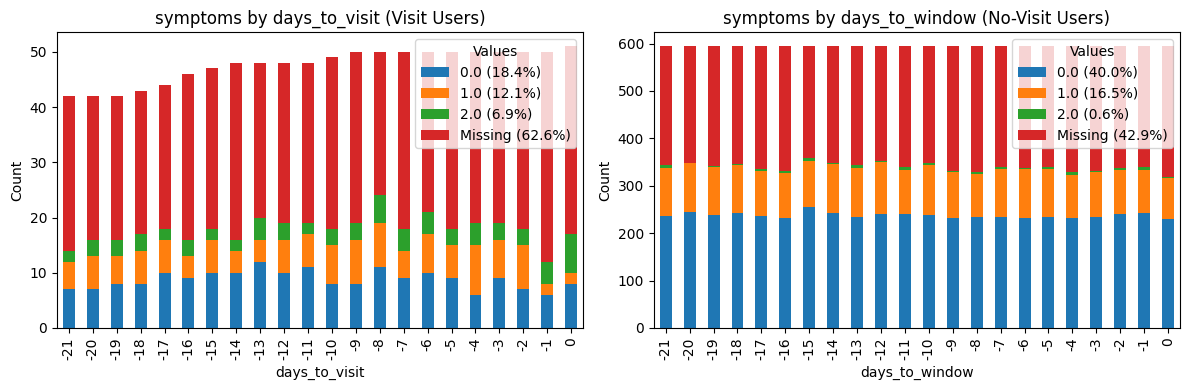

In [217]:
plot_feature_comparison(three_week_visit, three_week, 'symptoms', bin_continuous=False)

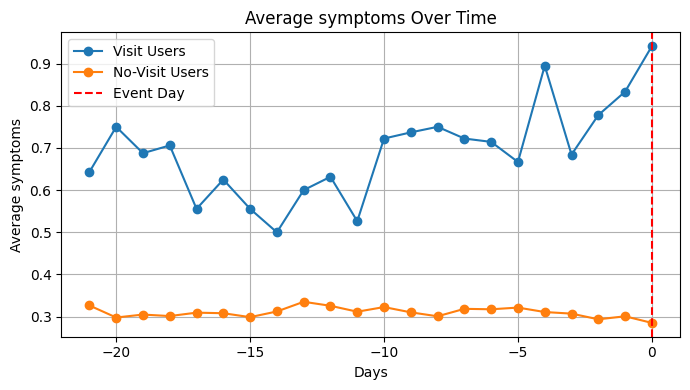

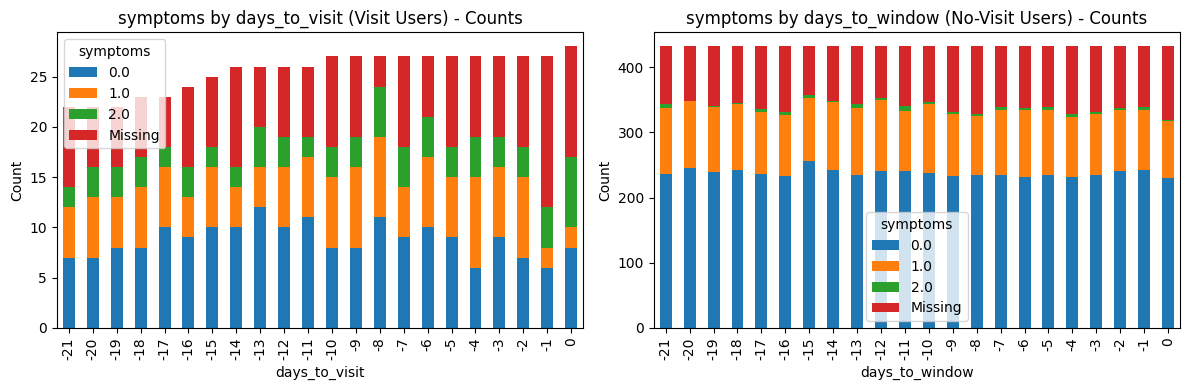

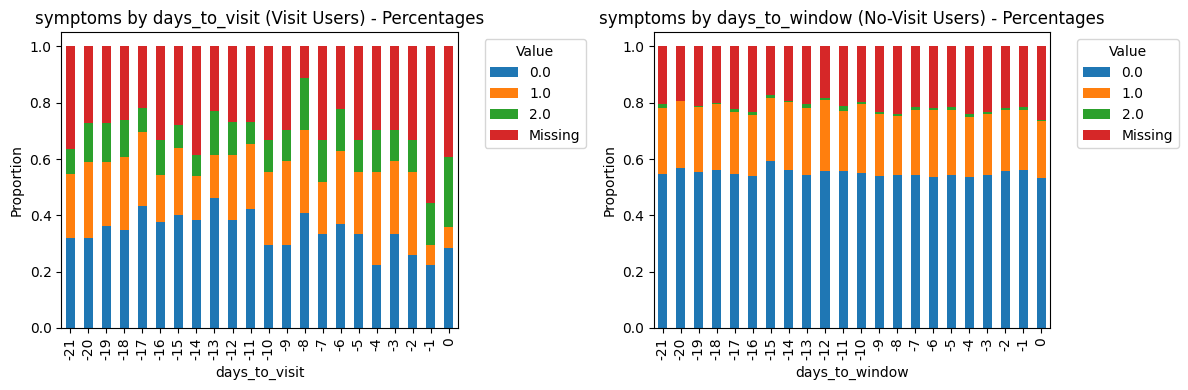

In [220]:
plot_feature_comparison(three_week_visit_symptoms, three_week_symptoms, 'symptoms', bin_continuous=False)

In [172]:
three_week_visit_hrv_deep = drop_nan_user(three_week_visit, 'hrv_deepRmssd_z')
three_week_hrv_deep = drop_nan_user(three_week, 'hrv_deepRmssd_z')

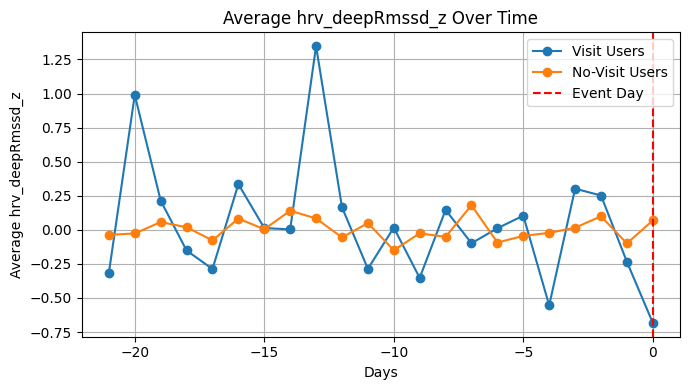

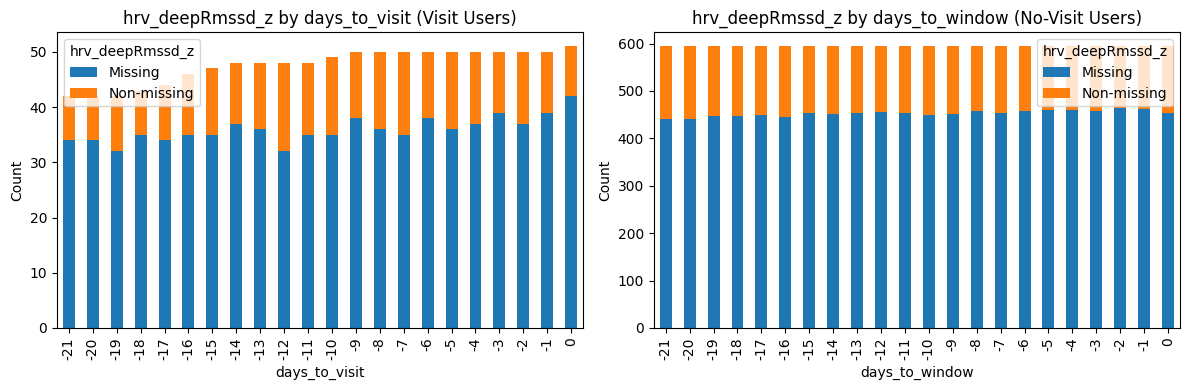

In [173]:
plot_feature_comparison(three_week_visit, three_week, 'hrv_deepRmssd_z', bin_continuous=True)

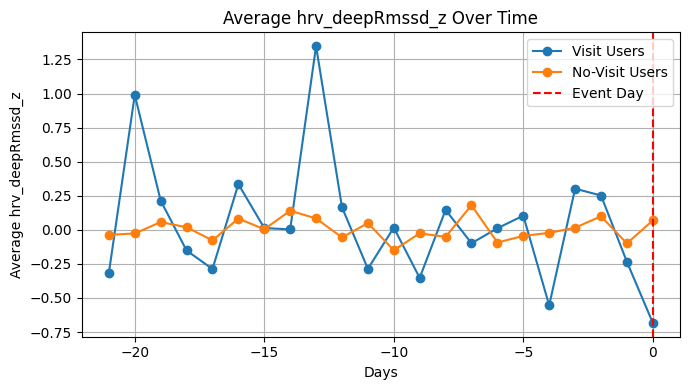

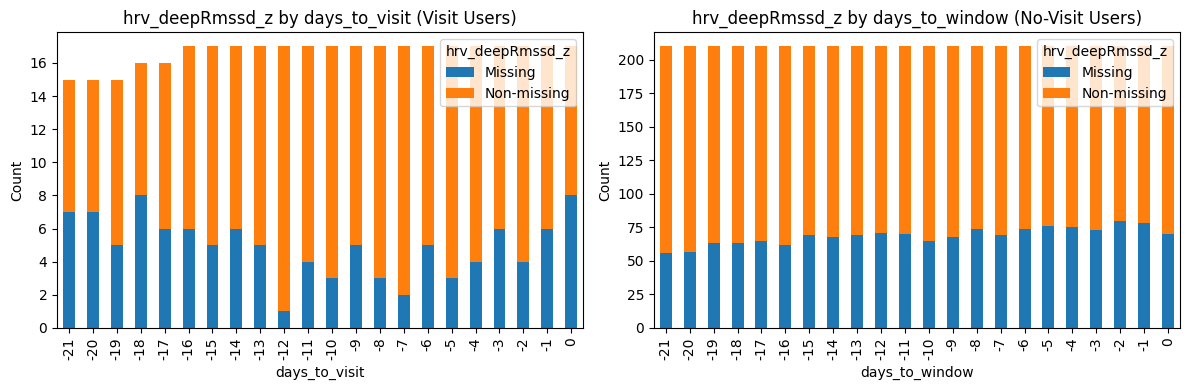

In [174]:
plot_feature_comparison(three_week_visit_hrv_deep, three_week_hrv_deep, 'hrv_deepRmssd_z', bin_continuous=True)

In [175]:
three_week_visit_hrv_daily = drop_nan_user(three_week_visit, 'hrv_dailyRmssd_z')
three_week_hrv_daily = drop_nan_user(three_week, 'hrv_dailyRmssd_z')

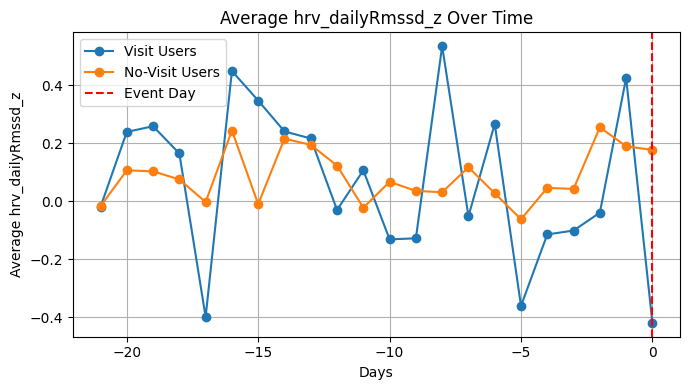

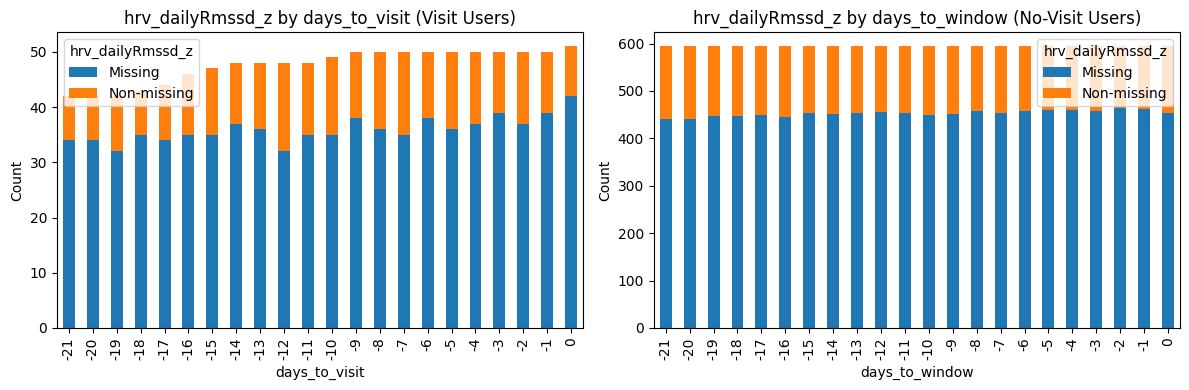

In [176]:
plot_feature_comparison(three_week_visit, three_week, 'hrv_dailyRmssd_z', bin_continuous=True)

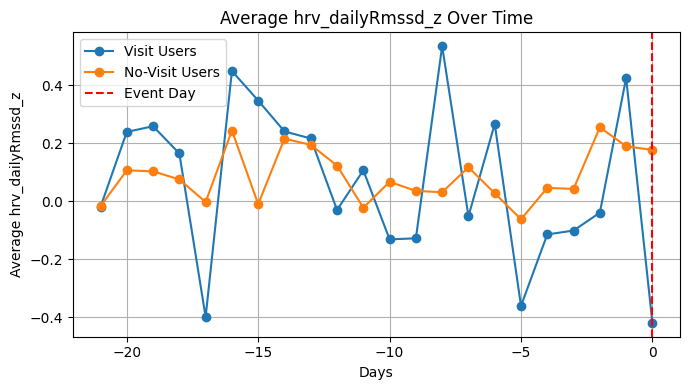

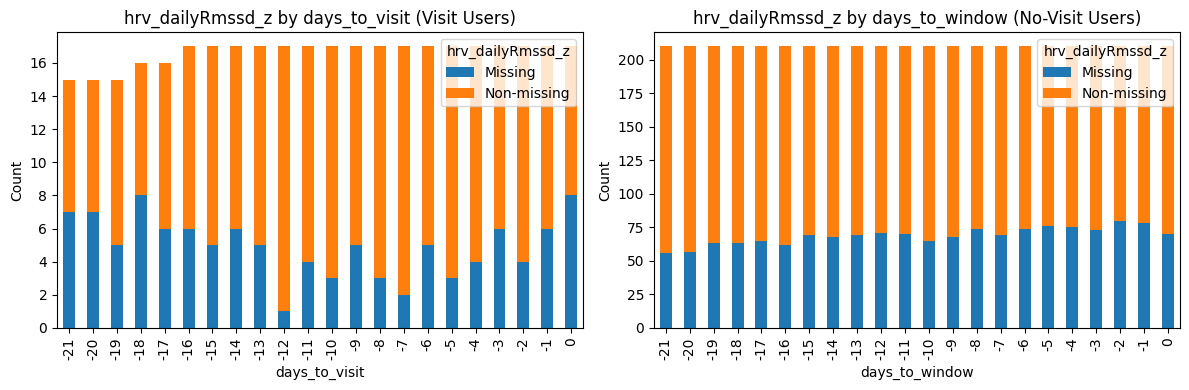

In [177]:
plot_feature_comparison(three_week_visit_hrv_daily, three_week_hrv_daily, 'hrv_dailyRmssd_z', bin_continuous=True)

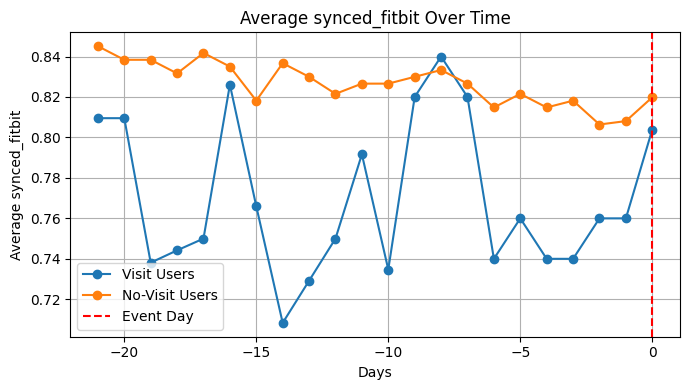

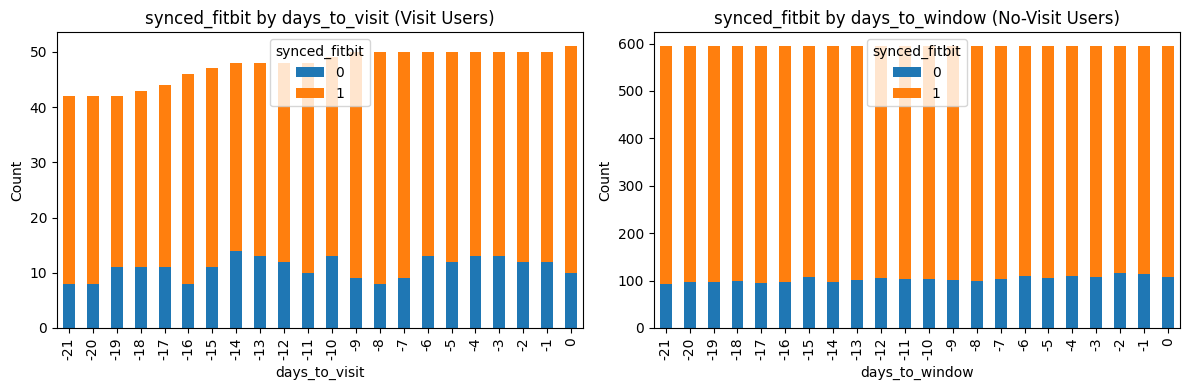

In [178]:
plot_feature_comparison(three_week_visit, three_week, 'synced_fitbit', bin_continuous=False)

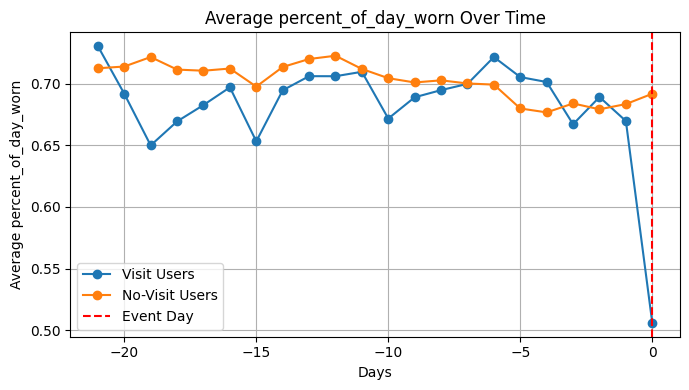

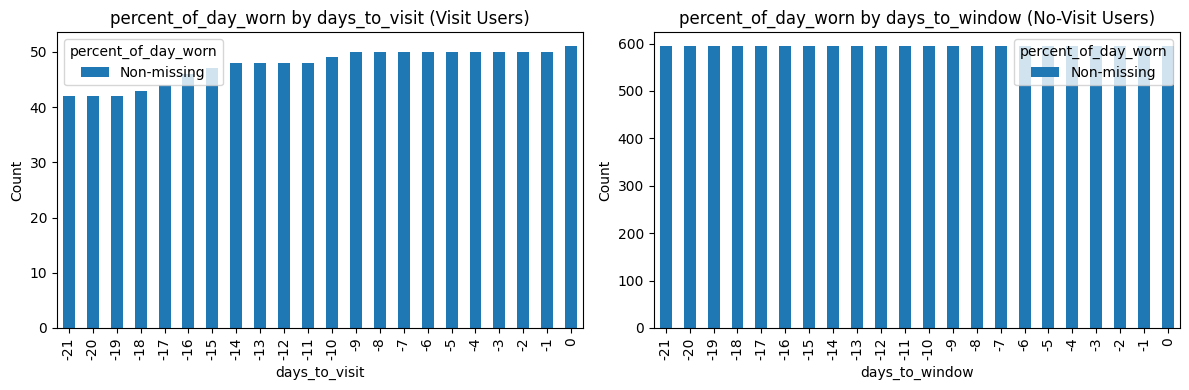

In [179]:
plot_feature_comparison(three_week_visit, three_week, 'percent_of_day_worn', bin_continuous=True)

In [180]:
three_week_visit_app = three_week_visit[three_week_visit['study_group'] != 'No App']
three_week_app = three_week[three_week['study_group'] != 'No App']

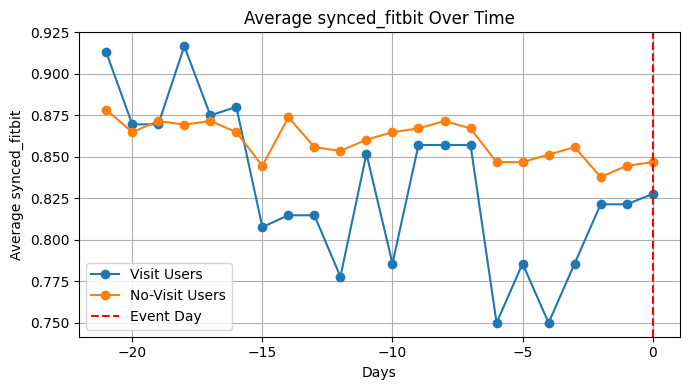

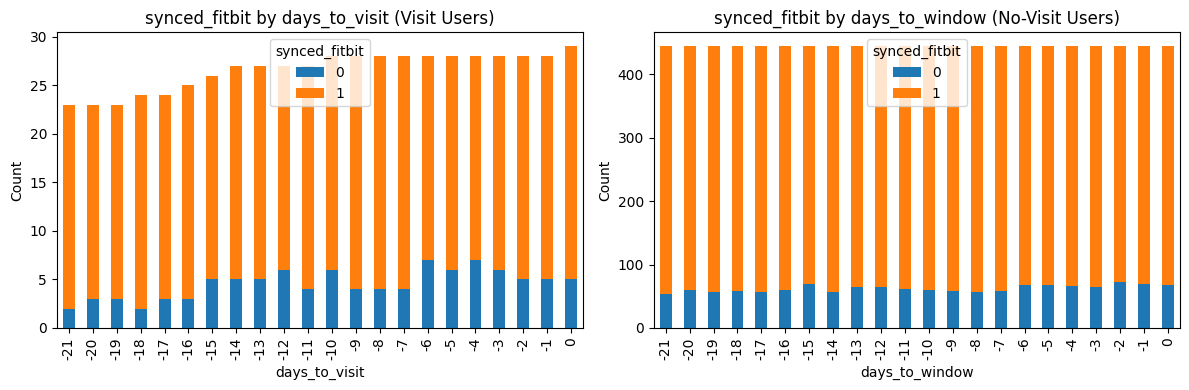

In [181]:
plot_feature_comparison(three_week_visit_app, three_week_app, 'synced_fitbit', bin_continuous=False)

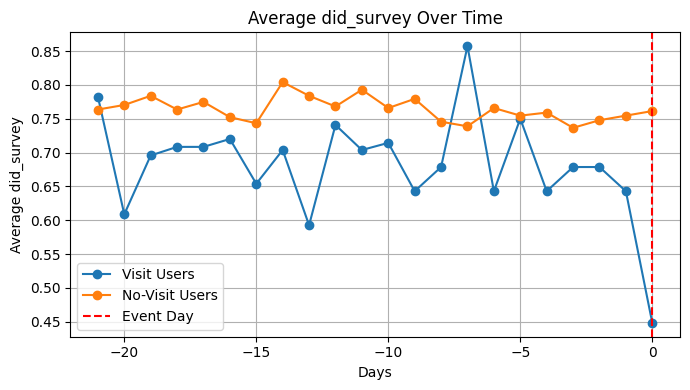

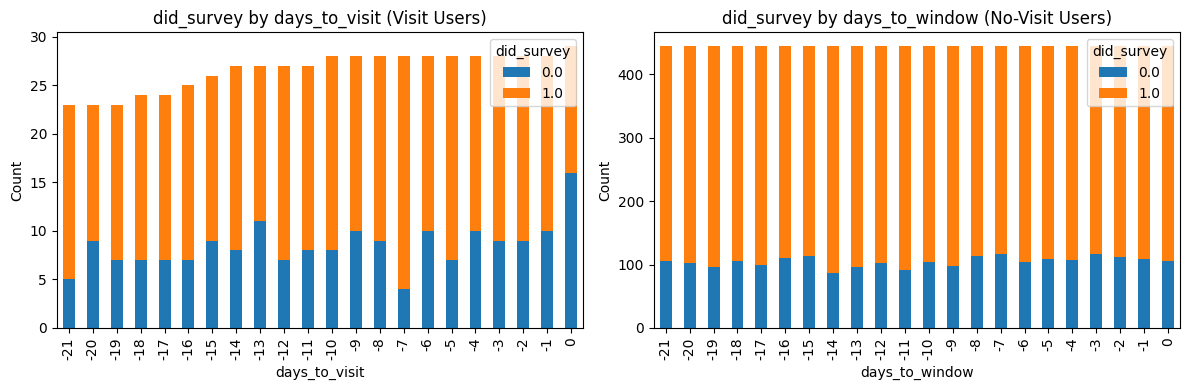

In [182]:
plot_feature_comparison(three_week_visit_app, three_week_app, 'did_survey', bin_continuous=False)

### 2b) Two Week

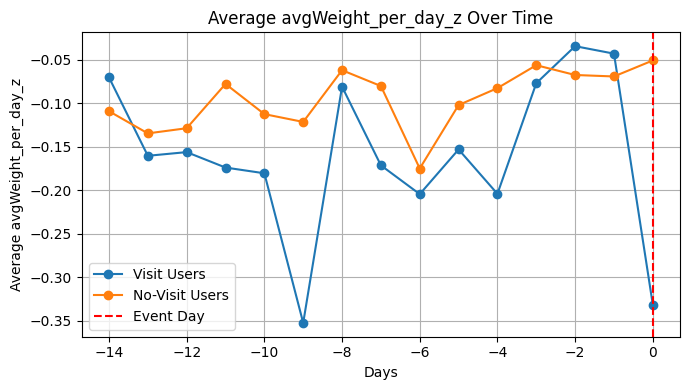

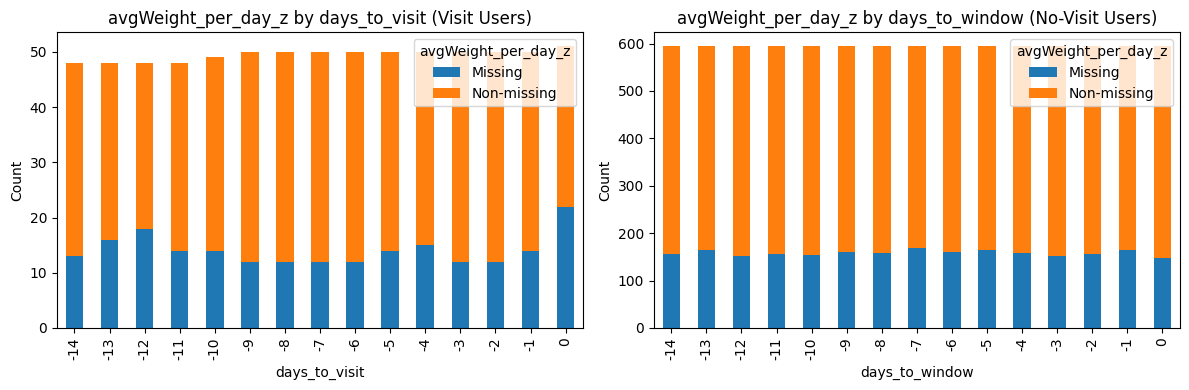

In [183]:
plot_feature_comparison(two_week_visit, two_week, 'avgWeight_per_day_z', bin_continuous=True, n_bins=10)

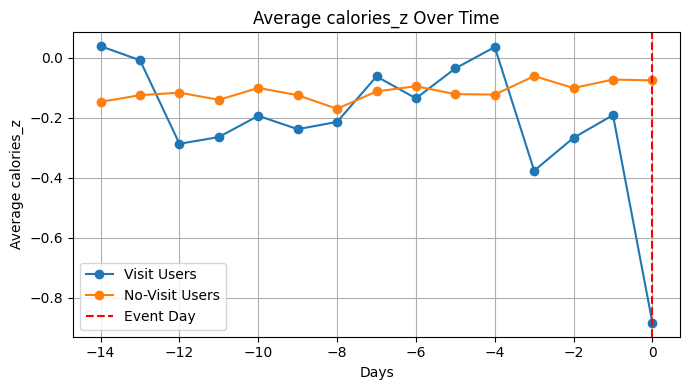

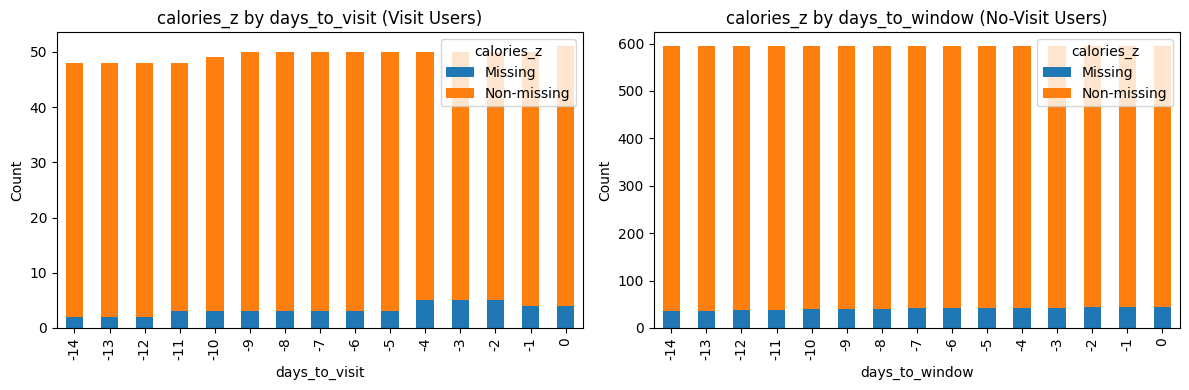

In [184]:
plot_feature_comparison(two_week_visit, two_week, 'calories_z', bin_continuous=True, n_bins=10)

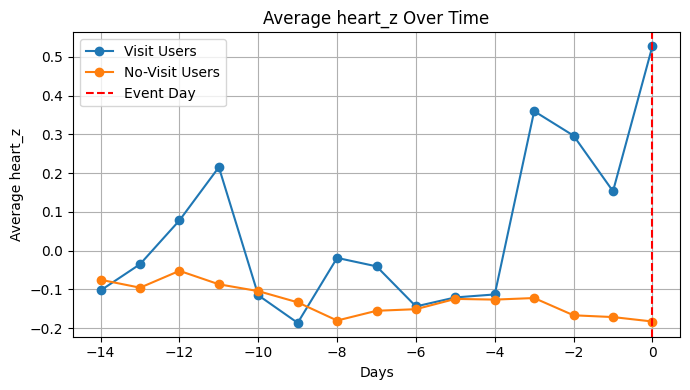

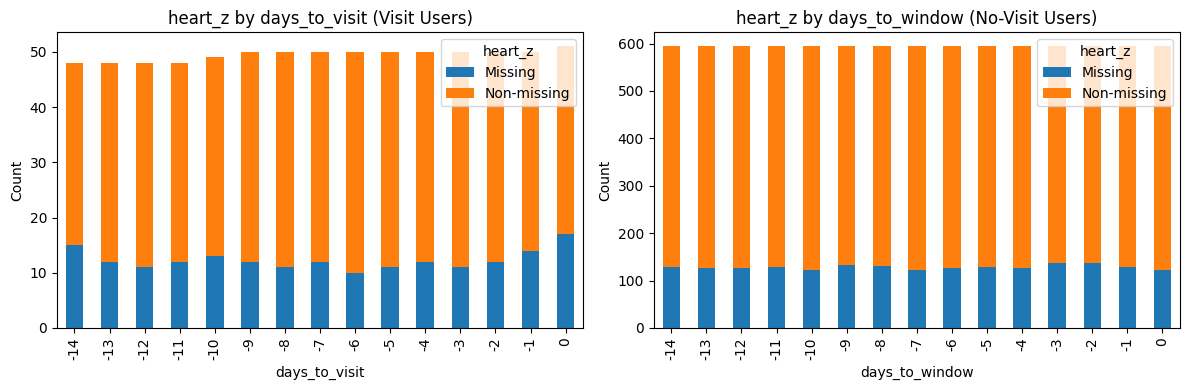

In [185]:
plot_feature_comparison(two_week_visit, two_week, 'heart_z', bin_continuous=True, n_bins=10)

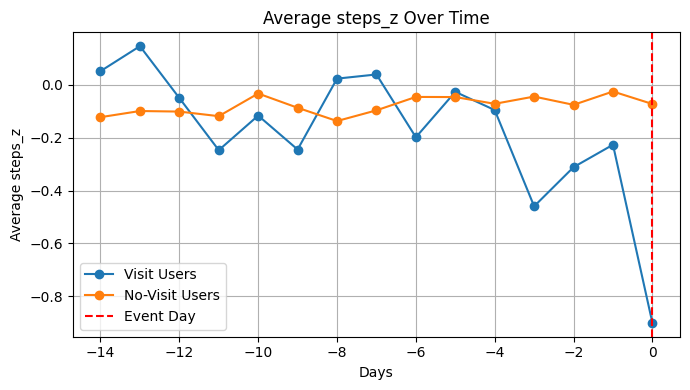

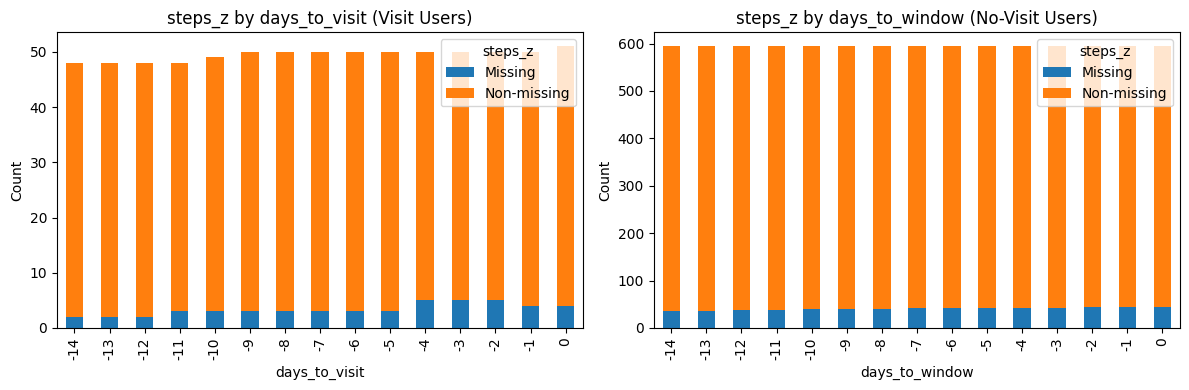

In [186]:
plot_feature_comparison(two_week_visit, two_week, 'steps_z', bin_continuous=True, n_bins=10)

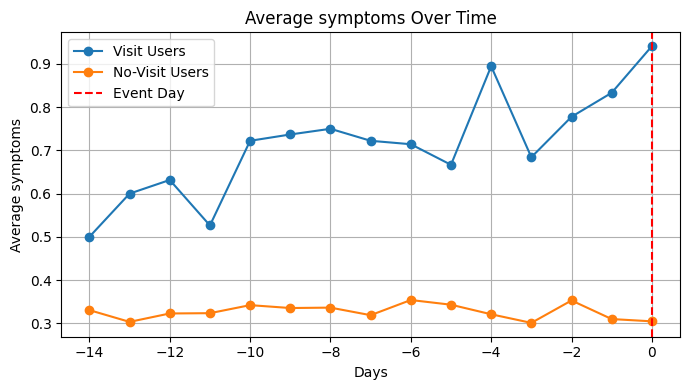

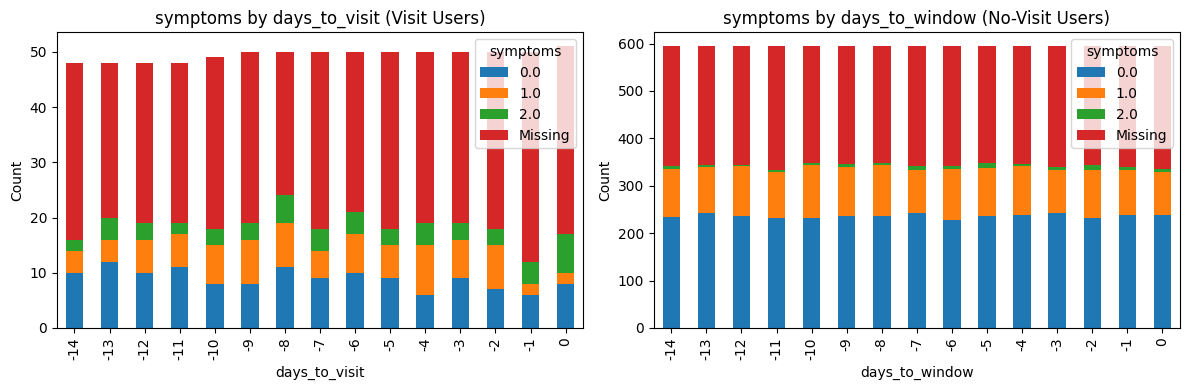

In [187]:
plot_feature_comparison(two_week_visit, two_week, 'symptoms', bin_continuous=False)

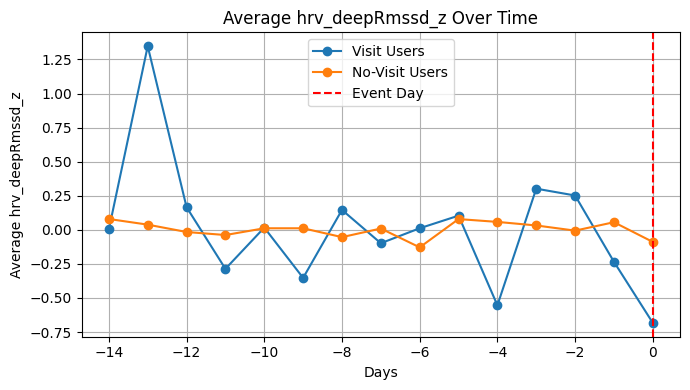

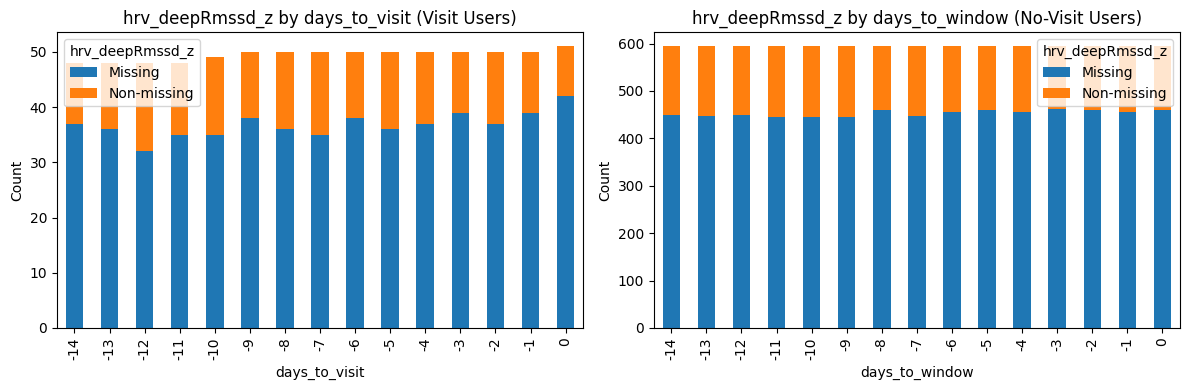

In [188]:
plot_feature_comparison(two_week_visit, two_week, 'hrv_deepRmssd_z', bin_continuous=True)

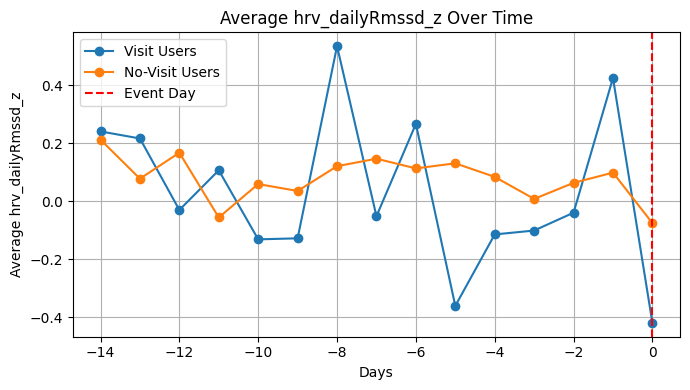

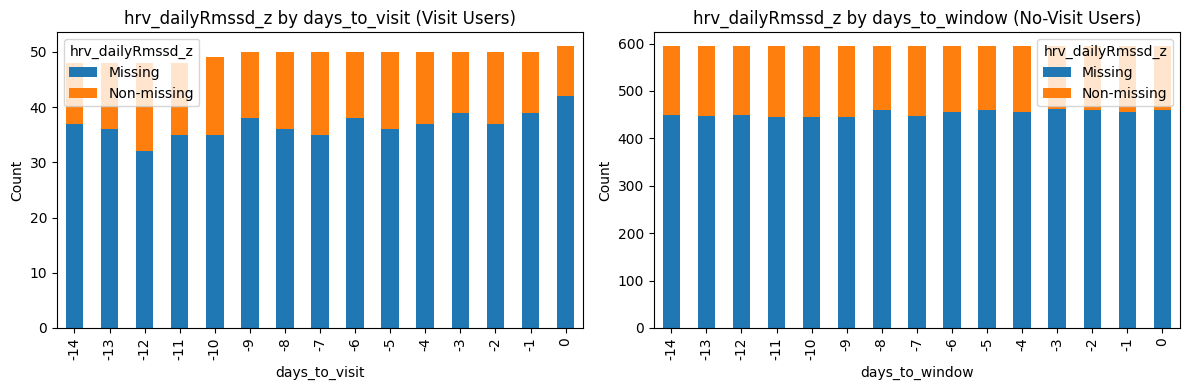

In [189]:
plot_feature_comparison(two_week_visit, two_week, 'hrv_dailyRmssd_z', bin_continuous=True)

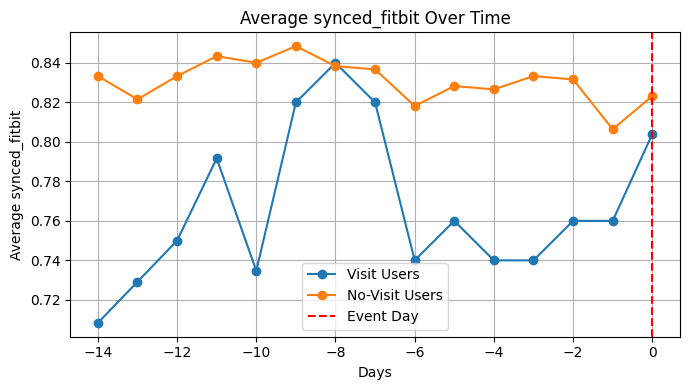

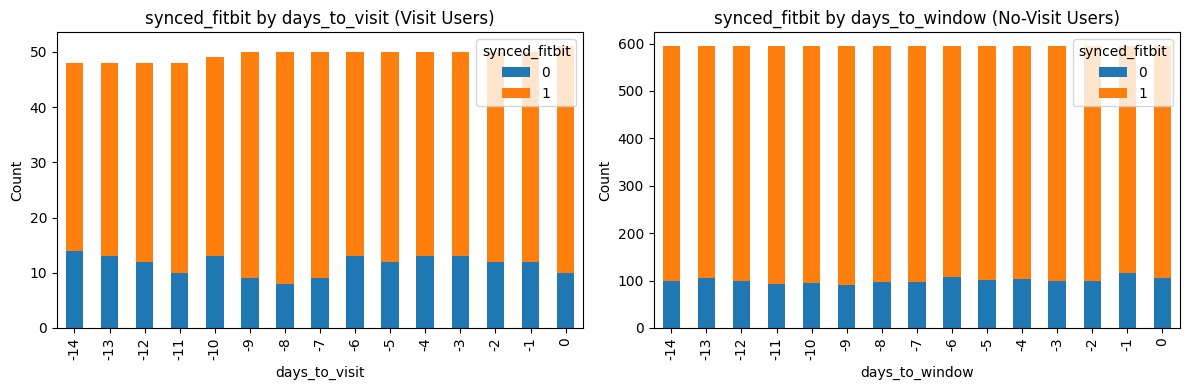

In [190]:
plot_feature_comparison(two_week_visit, two_week, 'synced_fitbit', bin_continuous=False)

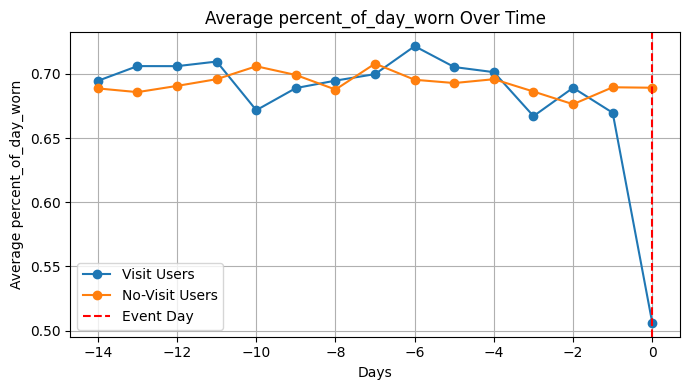

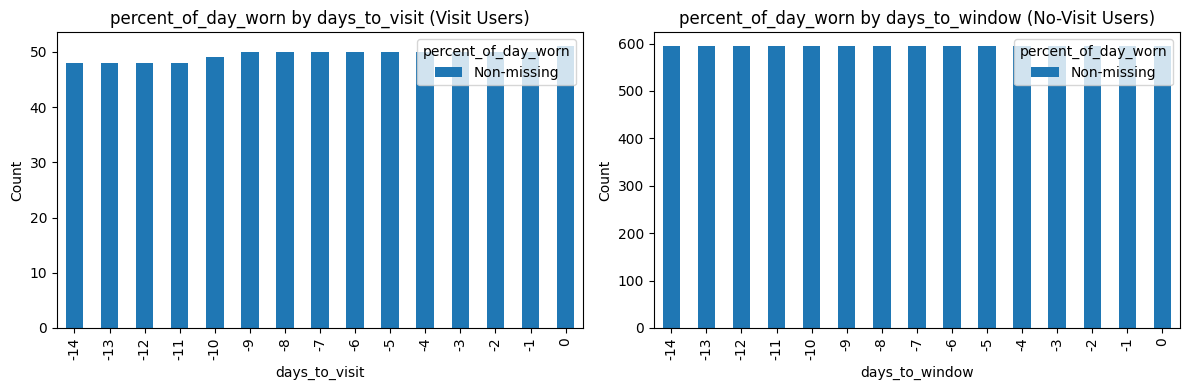

In [191]:
plot_feature_comparison(two_week_visit, two_week, 'percent_of_day_worn', bin_continuous=True)

In [192]:
two_week_visit_app = two_week_visit[two_week_visit['study_group'] != 'No App']
two_week_app = two_week[two_week['study_group'] != 'No App']

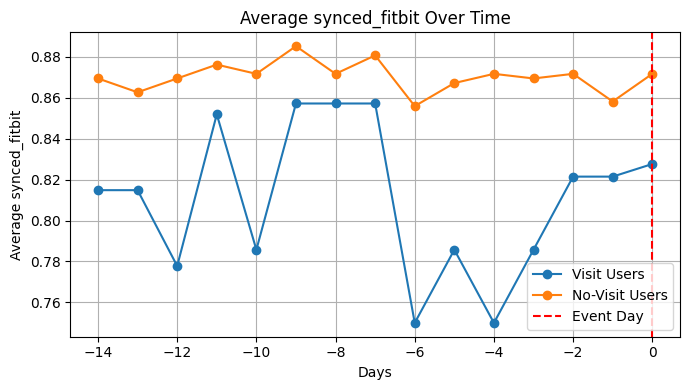

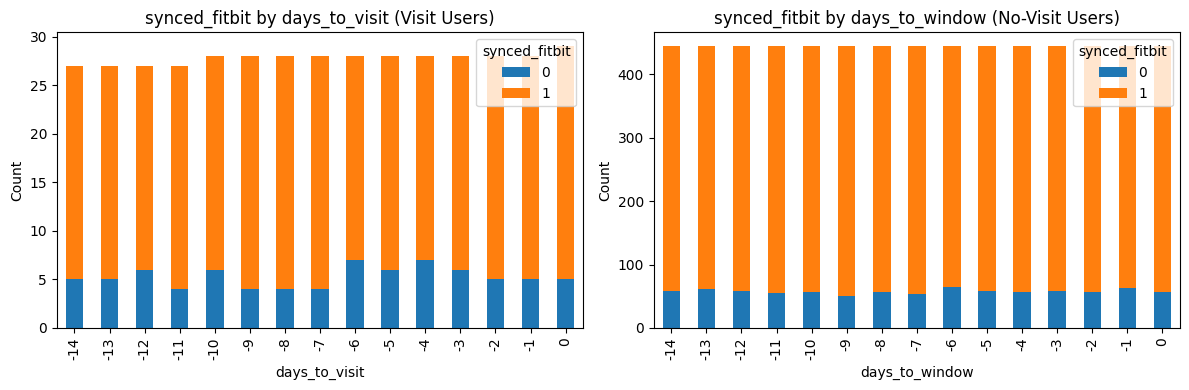

In [193]:
plot_feature_comparison(two_week_visit_app, two_week_app, 'synced_fitbit', bin_continuous=False)

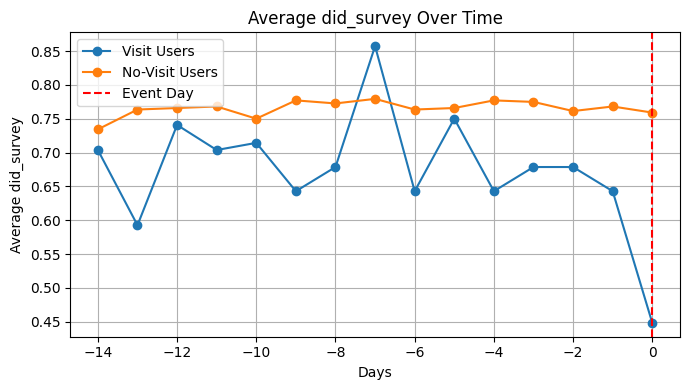

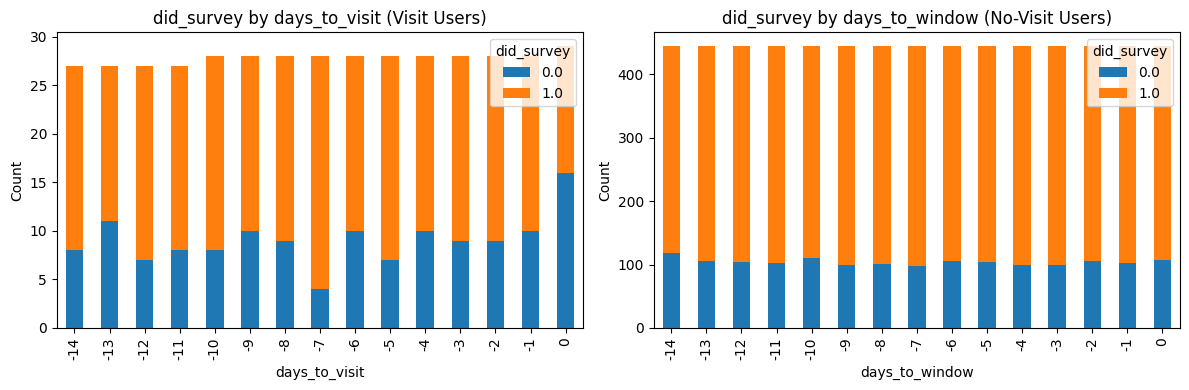

In [194]:
plot_feature_comparison(two_week_visit_app, two_week_app, 'did_survey', bin_continuous=False)

## 3) Additional Things to Try

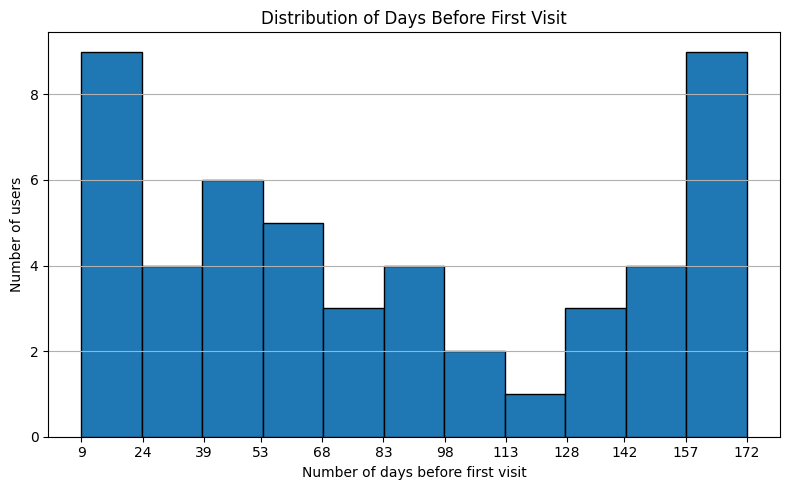

In [156]:
users_with_visit = full_fb_data[full_fb_data['has_visit'] == 1]
first_visit_days = users_with_visit[users_with_visit['visit_day'] == 1].groupby('fitbit_user_id')['days'].min()
merged = users_with_visit.merge(first_visit_days.rename('first_visit_day'), on='fitbit_user_id')
pre_visit = merged[merged['days'] < merged['first_visit_day']]
days_before_counts = pre_visit.groupby('fitbit_user_id').size()
n_bins = 11
min_val, max_val = days_before_counts.min(), days_before_counts.max()
bins = np.linspace(min_val, max_val, n_bins + 1)
plt.figure(figsize=(8, 5))
plt.hist(days_before_counts, bins=bins, edgecolor='black')
plt.xlabel("Number of days before first visit")
plt.ylabel("Number of users")
plt.title("Distribution of Days Before First Visit")
plt.xticks(np.round(bins))  # Rounded ticks for clarity
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [209]:
# checking hr
def check_hr(df, thresh):
  count = 0
  users = []
  user_count = 0

  for user_id, group in df.groupby('fitbit_user_id'):

    for r in group['heart']:

      if r > thresh:
        # print(str(user_id) + ' hr: ' + str(r))
        count += 1

        if user_id not in users:
          users.append(user_id)
          user_count += 1

  return count, user_count, users

In [210]:
check_hr(three_week_visit, 80)

(95, 7, [7, 28, 67, 126, 181, 215, 272])

In [211]:
check_hr(three_week, 80)

(441,
 20,
 [12,
  48,
  74,
  89,
  95,
  99,
  110,
  112,
  115,
  133,
  137,
  162,
  186,
  189,
  210,
  222,
  274,
  287,
  293,
  305])

In [212]:
check_hr(three_week_visit, 70)

(279,
 22,
 [7,
  28,
  32,
  49,
  67,
  103,
  105,
  126,
  156,
  158,
  180,
  181,
  192,
  196,
  198,
  215,
  218,
  227,
  257,
  267,
  272,
  284])

In [213]:
check_hr(three_week, 70)

(2998,
 79,
 [9,
  12,
  14,
  20,
  26,
  31,
  33,
  35,
  36,
  39,
  47,
  48,
  50,
  55,
  56,
  62,
  63,
  74,
  77,
  87,
  89,
  90,
  95,
  99,
  101,
  106,
  110,
  112,
  115,
  123,
  125,
  132,
  133,
  136,
  137,
  142,
  143,
  144,
  145,
  146,
  148,
  157,
  162,
  165,
  167,
  170,
  171,
  173,
  175,
  184,
  186,
  188,
  189,
  191,
  195,
  197,
  199,
  203,
  210,
  219,
  222,
  224,
  229,
  233,
  236,
  239,
  252,
  265,
  266,
  268,
  274,
  278,
  287,
  291,
  293,
  301,
  302,
  303,
  305])

## 4) Looking at Random Visit Windows

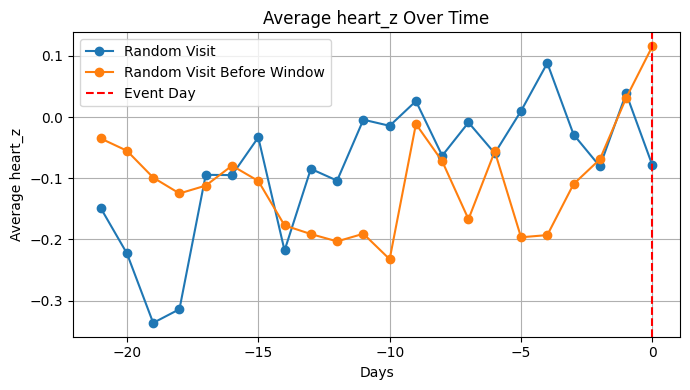

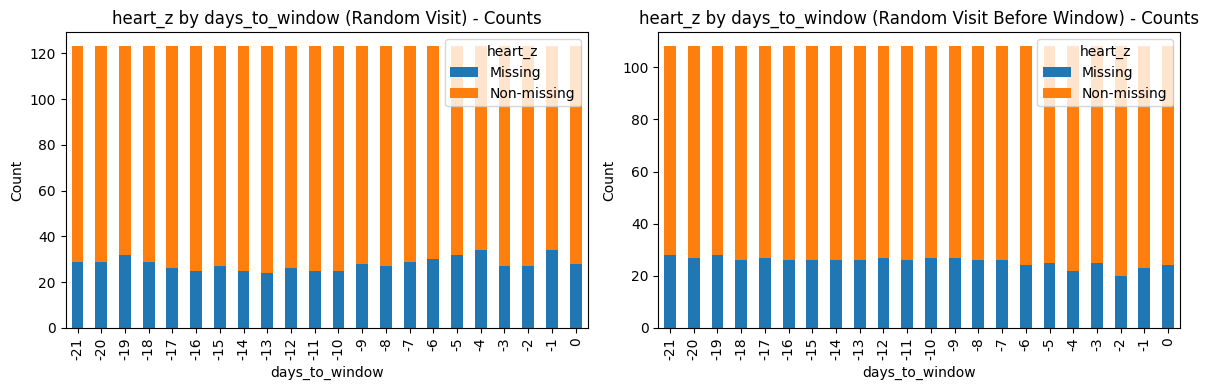

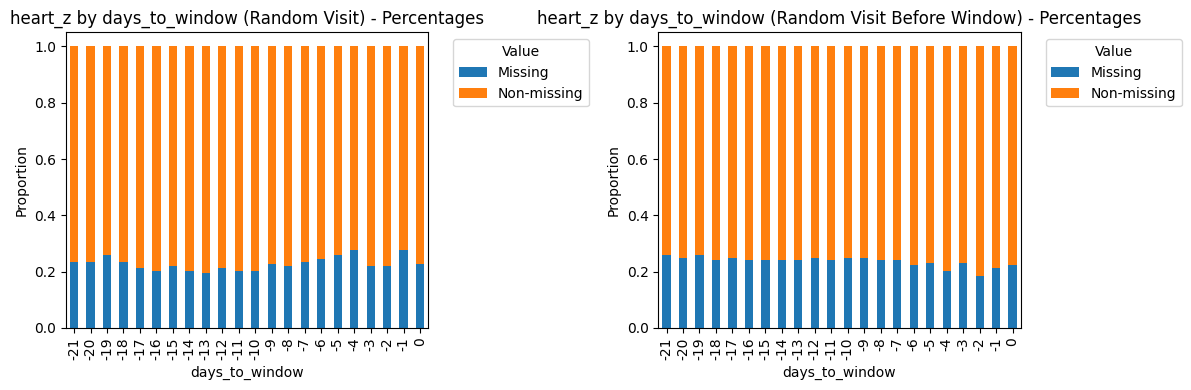

In [246]:
plot_feature_comparison(three_week_visit_random, three_week_visit_random_window, 'heart_z', time_col1='days_to_window', time_col2='days_to_window', label1='Random Visit', label2='Random Visit Before Window', bin_continuous = True)